# Single Elders Home Monitoring : PCA filtering

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import plotly
import plotly.express as px

plotly.offline.init_notebook_mode()
%matplotlib inline

In [2]:
no_occupants_df = pd.read_csv('./data/data_ref_until_2020-02-13.csv')

In [3]:
no_occupants_df.head()

timestamp  temperature  humidity  CO2CosIRValue  \
0  2020-01-25 00:01:49.251503+01:00        20.64     55.57          121.0   
1  2020-01-25 00:02:09.350082+01:00        20.64     55.53          122.0   
2  2020-01-25 00:02:29.319505+01:00        20.62     55.53          121.0   
3  2020-01-25 00:02:49.399379+01:00        20.62     55.57          121.0   
4  2020-01-25 00:03:09.158989+01:00        20.62     55.59          121.0   

   CO2MG811Value   MOX1   MOX2   MOX3   MOX4  COValue  
0          496.0  521.0  694.0  652.0  591.0    135.0  
1          495.0  521.0  694.0  652.0  591.0    135.0  
2          495.0  522.0  694.0  651.0  591.0    135.0  
3          495.0  522.0  694.0  651.0  591.0    135.0  
4          495.0  522.0  694.0  652.0  591.0    135.0

## Sliding window median filter

In [4]:
def sliding_window_median_filter(df, window_size):
    filtered_df = df.copy()

    for column in df.columns:
        filtered_df[column] = medfilt(df[column], kernel_size=window_size)
        #filtered_df[column] -= filtered_df[column].mean()

    return filtered_df

In [5]:
# filtering dataset of when no occupant is in the house

no_occupants_filtered_df = sliding_window_median_filter(no_occupants_df.drop(columns=['timestamp']), window_size=11)

scaler = StandardScaler(with_std=False)
no_occupants_filtered_df = scaler.fit_transform(no_occupants_filtered_df)

## PCA [fit] on no occupant data

In [6]:
# pca fit
pca = PCA(n_components=4)
filtered_no_occupants = pca.fit_transform(no_occupants_filtered_df)
print(pca.explained_variance_ratio_)

[0.69256201 0.17096992 0.05966838 0.04746386]


## PCA inference

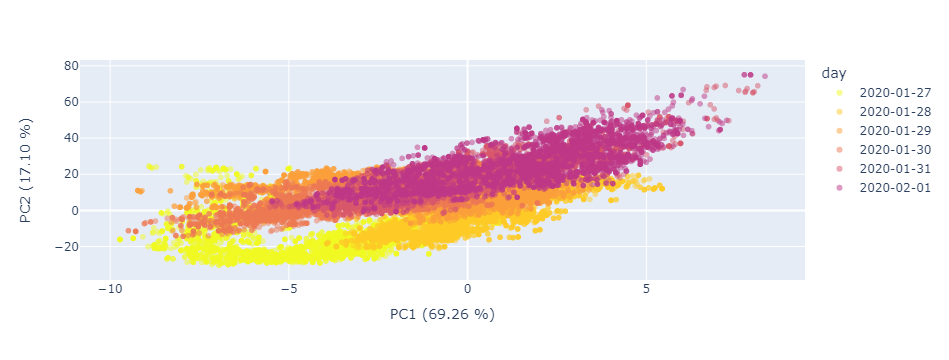

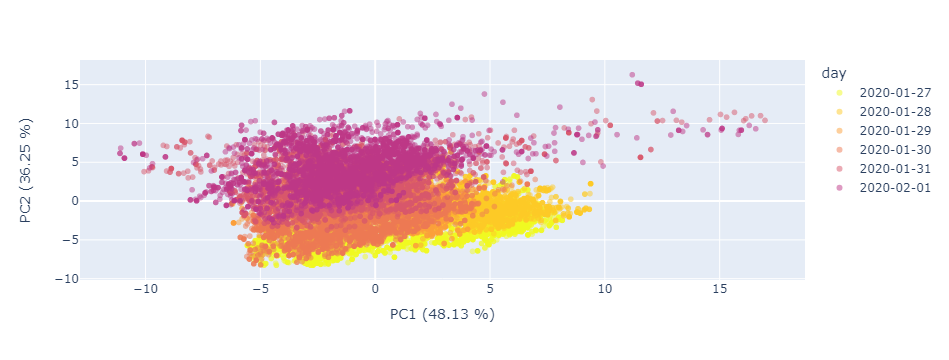

In [7]:
# visualization of PCA inference on no occupant data from 27/01/2020 to 01/02/2020

# Define the date range
start_date = '2020-01-27'
end_date = '2020-02-02'

# Query the DataFrame for the date range
visual_days = ((no_occupants_df['timestamp'] >= start_date) & (no_occupants_df['timestamp'] <= end_date))
visual_data = filtered_no_occupants[visual_days]
visual_data_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.date})
var_new_proj = pca.explained_variance_ratio_


fig = px.scatter(visual_data_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100)
)
fig.show()

###############################################################################################

transformed_data_without_first_component = visual_data.copy()

# removing first component of PCA by setting it to zero
transformed_data_without_first_component[:,0] = 0

# reprojecting data in original space without first component
inv_transf = pca.inverse_transform(transformed_data_without_first_component)

# building new PCA on data without first component
pca = PCA(n_components=2)
visual_data = pca.fit_transform(inv_transf)
var_new_proj = pca.explained_variance_ratio_

visual_data_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.date})

fig = px.scatter(visual_data_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100)
)
fig.show()